In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
conda install -c conda-forge scikit-plot

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install yfinance
!pip install investpy
!pip install pykrx
!pip install seaborn
!pip install workalendar
!pip install --upgrade finance-datareader
!pip install TA_Lib-0.4.19-cp38-cp38-win_amd64.whl
!pip install -U finance-datareader
!pip install keras

Processing c:\users\user\downloads\ta_lib-0.4.19-cp38-cp38-win_amd64.whl
TA-Lib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
# 크롤링 start_date, end_date
#start_date='2017-01-05'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
#end_date='2021-01-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
#train_date = '2020-01-01'
start_date = '2005-01-01'
end_date = '2021-01-19'
train_date = '2019-01-01'

In [6]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [7]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

# 2) 볼린저밴드 (주가의 이동평균선을 중심으로 표준편차 범위를 표시)
ubb, mbb, lbb = ta.BBANDS(model_samsung.Close, 20, 2)
model_samsung['ubb'] = ubb
model_samsung['mbb'] = mbb
model_samsung['lbb'] = lbb

# 1) 이평선(SMA, EMA, WMA) (w = 5,10,15,20,30,60,120)
model_samsung['ma_5'] = ta.SMA(model_samsung.Close, timeperiod=5)
model_samsung['ma_10'] = ta.SMA(model_samsung.Close, timeperiod=10)
model_samsung['ma_15'] = ta.SMA(model_samsung.Close, timeperiod=15)
model_samsung['ma_20'] = ta.SMA(model_samsung.Close, timeperiod=20)
model_samsung['ma_30'] = ta.SMA(model_samsung.Close, timeperiod=30)
model_samsung['ma_60'] = ta.SMA(model_samsung.Close, timeperiod=60)
model_samsung['ma_120'] = ta.SMA(model_samsung.Close, timeperiod=120)

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']

# SOX 지수
SOX = yf.download("^SOX", start=start_date, end=end_date)
SOX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOX = SOX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
model_samsung['exchange_rate_usd'] = exchange_rate_usd_
#model_samsung['nasdaq'] = nasdaq_
#model_samsung['russell_2000'] = russell_2000_
#model_samsung['MSCI_KR'] = MSCI_KR
#model_samsung['SOX'] = SOX
model_samsung['treasury_5y'] = treasury_5y_



In [9]:
# samsung 모델
model_samsung['Labeling'] = model_samsung['Close'].shift(-1)
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거
model_samsung.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

,Close,macd,macdsignal9,macdhist,ubb,mbb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60,ma_120,exchange_rate_usd,treasury_5y,Labeling
날짜,,,,,,,,,,,,,,,,,
2005-06-28,9790,27.139375,38.036221,-10.896846,10049.545027,9808.0,9566.454973,9840.0,9861.0,9832.000000,9808.0,9818.000000,9751.500000,9812.583333,1023.50,3.753,9800.0
2005-06-29,9800,22.927333,35.014444,-12.087111,10050.238471,9809.0,9567.761529,9828.0,9841.0,9848.666667,9809.0,9818.333333,9744.166667,9819.083333,1031.50,3.769,9880.0
2005-06-30,9880,25.747786,33.161112,-7.413326,10056.767378,9814.0,9571.232622,9812.0,9832.0,9867.333333,9814.0,9821.333333,9736.500000,9826.916667,1035.50,3.725,10020.0
2005-07-01,10020,38.832212,34.295332,4.536880,10084.161255,9827.5,9570.838745,9852.0,9847.0,9880.000000,9827.5,9823.000000,9730.833333,9836.583333,1034.50,3.825,10060.0
2005-07-05,10040,59.830712,42.208258,17.622454,10128.605367,9864.0,9599.394633,9960.0,9900.0,9894.000000,9864.0,9828.666667,9719.166667,9858.166667,1049.50,3.899,10080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-11,91000,4877.198339,3842.490073,1034.708266,89159.064709,78040.0,66920.935291,85760.0,82760.0,79540.000000,78040.0,75356.666667,68418.333333,62972.500000,1097.23,0.498,90600.0
2021-01-12,90600,5175.725651,4109.137188,1066.588463,91039.763720,78925.0,66810.236280,87100.0,84040.0,80693.333333,78925.0,76110.000000,68928.333333,63279.166667,1094.48,0.503,89700.0
2021-01-13,89700,5278.837071,4343.077165,935.759906,92437.464314,79740.0,67042.535686,88600.0,85140.0,81806.666667,79740.0,76826.666667,69431.666667,63573.333333,1097.12,0.476,89700.0


In [10]:
model_samsung.iloc[0:4]

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,ubb,mbb,...,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60,ma_120,exchange_rate_usd,treasury_5y,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2005-06-28,9770,9809,9710,9790,370658,27.139375,38.036221,-10.896846,10049.545027,9808.0,...,9840.0,9861.0,9832.000000,9808.0,9818.000000,9751.500000,9812.583333,1023.5,3.753,9800.0
2005-06-29,9800,9850,9760,9800,383764,22.927333,35.014444,-12.087111,10050.238471,9809.0,...,9828.0,9841.0,9848.666667,9809.0,9818.333333,9744.166667,9819.083333,1031.5,3.769,9880.0
2005-06-30,9800,9960,9800,9880,396777,25.747786,33.161112,-7.413326,10056.767378,9814.0,...,9812.0,9832.0,9867.333333,9814.0,9821.333333,9736.500000,9826.916667,1035.5,3.725,10020.0
2005-07-01,9880,10020,9860,10020,531182,38.832212,34.295332,4.536880,10084.161255,9827.5,...,9852.0,9847.0,9880.000000,9827.5,9823.000000,9730.833333,9836.583333,1034.5,3.825,10060.0


In [11]:
model_samsung.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'macd', 'macdsignal9',
       'macdhist', 'ubb', 'mbb', 'lbb', 'ma_5', 'ma_10', 'ma_15', 'ma_20',
       'ma_30', 'ma_60', 'ma_120', 'exchange_rate_usd', 'treasury_5y',
       'Labeling'],
      dtype='object')

In [12]:
len(model_samsung.columns)
model_samsung_col = []
##  model_Samsung feature 명 columns 생성
for i in range(len(model_samsung.columns)):
    model_samsung_col.append(model_samsung.columns[i])

In [13]:
model_samsung_col

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'macd',
 'macdsignal9',
 'macdhist',
 'ubb',
 'mbb',
 'lbb',
 'ma_5',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_30',
 'ma_60',
 'ma_120',
 'exchange_rate_usd',
 'treasury_5y',
 'Labeling']

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
model_samsung_col
df_scaled = scaler.fit_transform(model_samsung)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = model_samsung_col



#df_scaled.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

print(df_scaled)

          Open      High       Low     Close    Volume      macd  macdsignal9  \
0     0.108195  0.101333  0.108492  0.019795  0.004104  0.413457     0.389418   
1     0.108527  0.101756  0.109050  0.019916  0.004250  0.412988     0.389018   
2     0.108527  0.102893  0.109497  0.020881  0.004394  0.413302     0.388772   
3     0.109413  0.103512  0.110168  0.022571  0.005882  0.414758     0.388923   
4     0.111628  0.104752  0.111732  0.022812  0.002060  0.417094     0.389970   
...        ...       ...       ...       ...       ...       ...          ...   
3692  0.996678  1.000000  1.000000  1.000000  1.000000  0.953023     0.892939   
3693  1.000000  0.944215  0.981006  0.995172  0.539082  0.986234     0.928230   
3694  0.994463  0.942149  0.995531  0.984309  0.399406  0.997705     0.959192   
3695  0.982281  0.929752  0.991061  0.984309  0.292272  1.000000     0.984508   
3696  0.994463  0.948347  0.983240  0.963790  0.370205  0.979992     1.000000   

      macdhist       ubb   

In [15]:
df_scaled.info

<bound method DataFrame.info of           Open      High       Low     Close    Volume      macd  macdsignal9  \
0     0.108195  0.101333  0.108492  0.019795  0.004104  0.413457     0.389418   
1     0.108527  0.101756  0.109050  0.019916  0.004250  0.412988     0.389018   
2     0.108527  0.102893  0.109497  0.020881  0.004394  0.413302     0.388772   
3     0.109413  0.103512  0.110168  0.022571  0.005882  0.414758     0.388923   
4     0.111628  0.104752  0.111732  0.022812  0.002060  0.417094     0.389970   
...        ...       ...       ...       ...       ...       ...          ...   
3692  0.996678  1.000000  1.000000  1.000000  1.000000  0.953023     0.892939   
3693  1.000000  0.944215  0.981006  0.995172  0.539082  0.986234     0.928230   
3694  0.994463  0.942149  0.995531  0.984309  0.399406  0.997705     0.959192   
3695  0.982281  0.929752  0.991061  0.984309  0.292272  1.000000     0.984508   
3696  0.994463  0.948347  0.983240  0.963790  0.370205  0.979992     1.000000

In [16]:
TEST_SIZE = 300

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [17]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [18]:
df_scaled.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'macd', 'macdsignal9',
       'macdhist', 'ubb', 'mbb', 'lbb', 'ma_5', 'ma_10', 'ma_15', 'ma_20',
       'ma_30', 'ma_60', 'ma_120', 'exchange_rate_usd', 'treasury_5y',
       'Labeling'],
      dtype='object')

In [19]:
##  model_Samsung feature 명 columns 생성
feature_cols = []
label_cols = []
for i in range(len(df_scaled.columns)):
    if 'Close' == df_scaled.columns[i]:
        label_cols.append(df_scaled.columns[i])
    else :
        feature_cols.append(df_scaled.columns[i])

In [20]:
#feature_cols = ['시가', '고가', '저가', '거래량']
#label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)


In [21]:




# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((280, 20, 20), (280, 1))

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
MODEL_DIR = 'C:/Users/user/Downloads/model'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

model_path="C:/Users/user/Downloads/model"

early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])


Epoch 1/200
165/169 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00001: val_loss improved from inf to 0.00029, saving model to C:/Users/user/Downloads/model\tmp_checkpoint.h5
169/169 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 2.8604e-04
Epoch 2/200
168/169 [============================>.] - ETA: 0s - loss: 2.3132e-04
Epoch 00002: val_loss improved from 0.00029 to 0.00018, saving model to C:/Users/user/Downloads/model\tmp_checkpoint.h5
169/169 [==============================] - 1s 8ms/step - loss: 2.3144e-04 - val_loss: 1.8370e-04
Epoch 3/200
162/169 [===========================>..] - ETA: 0s - loss: 1.4968e-04
Epoch 00003: val_loss improved from 0.00018 to 0.00015, saving model to C:/Users/user/Downloads/model\tmp_checkpoint.h5
169/169 [==============================] - 1s 8ms/step - loss: 1.5384e-04 - val_loss: 1.4661e-04
Epoch 4/200
168/169 [============================>.] - ETA: 0s - loss: 1.3943e-04
Epoch 00004: val_loss improved f

In [24]:
# weight 로딩
model.load_weights(filename)


In [25]:
pred = model.predict(test_feature)

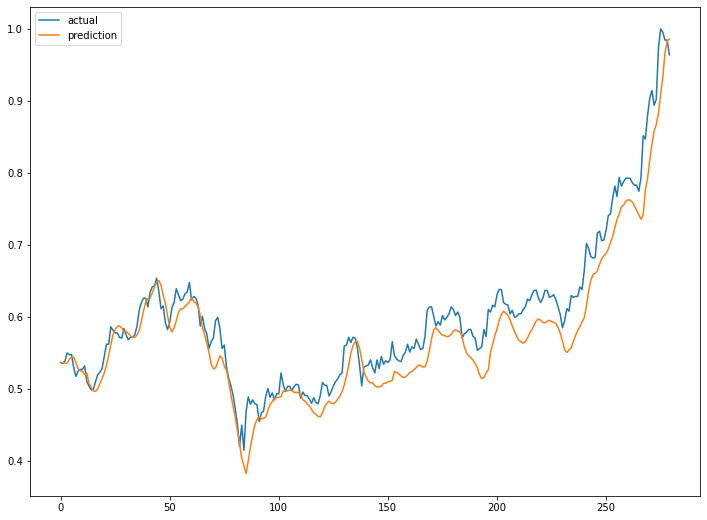

In [26]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()